# Gym crowdness predictor

## Goal

Predict the best time to go to the gym and avoid crowds, so you can enjoy a great workout 

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report



## Load data

In [6]:
crw = pd.read_csv('data/gym_crowdness.csv')

## EDA

In [19]:
crw.shape

(62184, 11)

In [20]:
crw.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [21]:
crw.isna().sum()

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

In [22]:
print(crw['date'].min())
print(crw['date'].max())

2015-08-14 17:00:11-07:00
2017-03-18 19:22:51-07:00


In [7]:
crw['date'] = pd.to_datetime(crw['date'], utc=True) 
crw['date_trucated'] = crw['date'].dt.date
crw['date_trucated'].value_counts().describe()

count    540.000000
mean     115.155556
std       28.844119
min        1.000000
25%       99.000000
50%      100.000000
75%      143.000000
max      199.000000
Name: count, dtype: float64

In [24]:
crw.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


### Observations

- Date is decomposed in other features, day of week, month, hour, timestamp
- There are other variables that bring interesting data like temperature, if is start of semester, if is during semester, if is weekend, if is holiday
- There is no missing data
- The number of people at the gym goes from 0 to 128
- We have data on 540 days
  - Min observations in a day 1
  - Max observations in a day 199
  - Avg observations in a day 115
  - The dataset is not balanced, we need to keep this in mind
- Timestamp starts at 0 at 7am
- On average there are 29 people
- 30% of the data is on weekend
- 0.2% is on weekeend, this column looks like wont be really needed
- 7.8% of the data is at the start of the semester
- 66% is during the semester

## Model building

### Feature selection

In [25]:
numerical_feats = crw.select_dtypes(include=['number']).columns
categorical_feats = crw.select_dtypes(include=['object']).columns

print(numerical_feats)
print(categorical_feats)

Index(['number_people', 'timestamp', 'day_of_week', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'month',
       'hour'],
      dtype='object')
Index(['date_trucated'], dtype='object')


In [26]:
abs(crw[numerical_feats].corr()['number_people']).sort_values(ascending=False)

number_people           1.000000
hour                    0.552049
timestamp               0.550218
temperature             0.373327
is_during_semester      0.335350
is_start_of_semester    0.182683
is_weekend              0.173958
day_of_week             0.162062
month                   0.097854
is_holiday              0.048249
Name: number_people, dtype: float64

- The most relevant features linearly correlated with **number_people**
  - hour and timestamp, they both get the same data, we will use only hour
  - temperature
  - is_during_semester
  - is_weekend

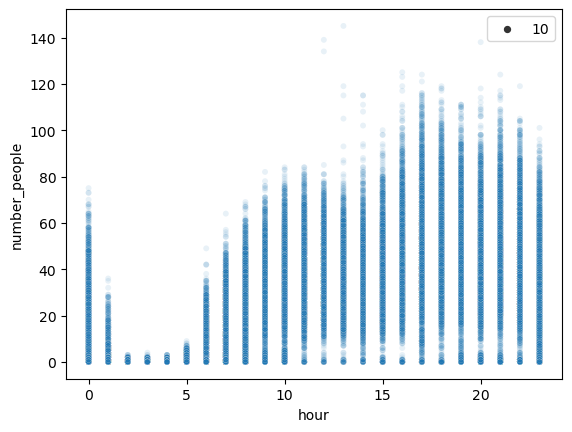

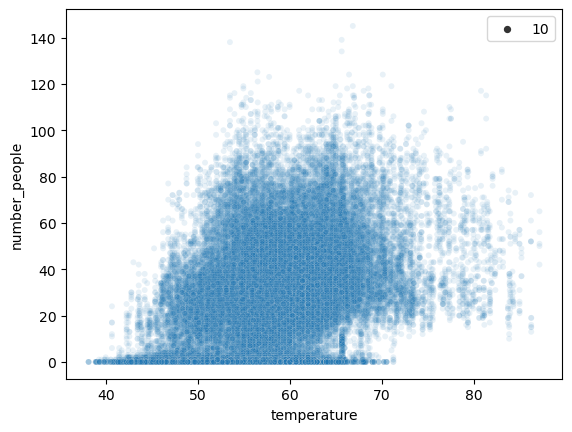

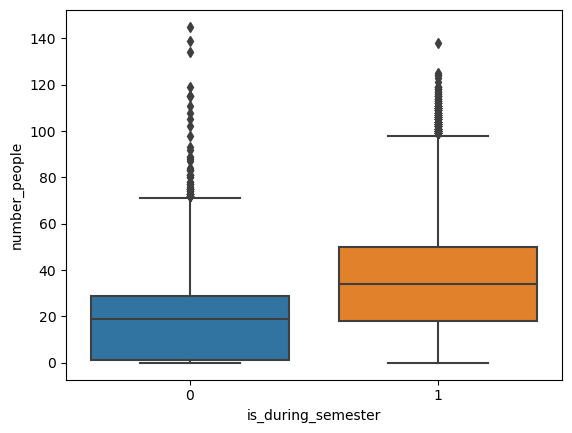

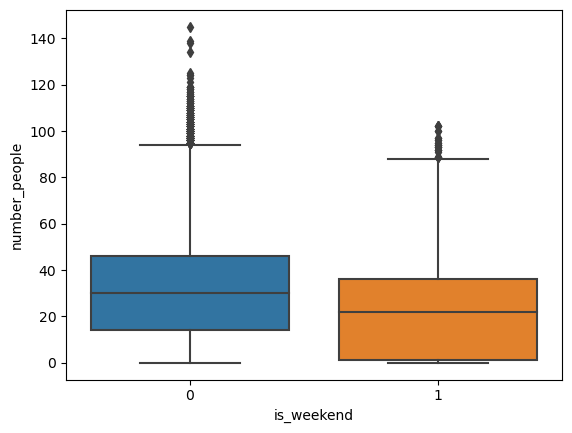

In [41]:
cols = ['hour', 'temperature', 'is_during_semester', 'is_weekend']

for col in cols:
    if col in ['is_during_semester', 'is_weekend']:
        sns.boxplot(x=col, y='number_people', data=crw)
    else:
        sns.scatterplot(x=col, y='number_people', data=crw, alpha=0.1, size=10)
    plt.show()

- The gym looks less crowded form 12pm to around 7 am
- The avg of is_during semester looks relevant

### Train and test datasets

In [66]:
X = crw[['hour', 'temperature', 'is_during_semester', 'is_weekend']]
y = crw['number_people']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.20)

In [68]:
# Normalizing the data
ss = StandardScaler()

X_train_s = ss.fit_transform(X_train)
X_test_s = ss.transform(X_test)

### Train model

In [69]:
sgdr = SGDRegressor(max_iter=10000,
                    eta0=1e-4,
                    tol=1e-4)

In [70]:
sgdr.fit(X_train_s, y_train)

y_pred = np.round(sgdr.predict(X_test_s)) #rounding because we are talking about people

MSE: 263.76
R2: 0.49
MAE: 12.38




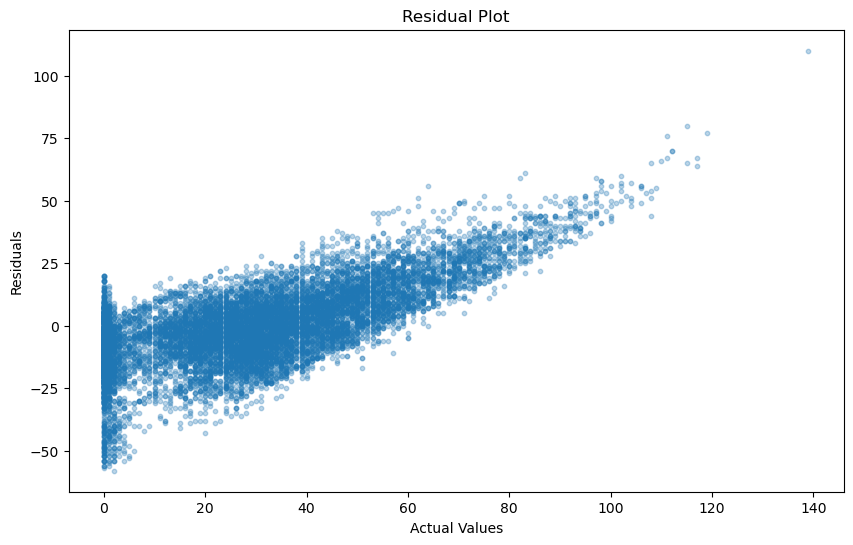

In [71]:
# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

residuals = y_test - y_pred

print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print('\n')
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, s=10, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


- MSE: the model has a moderate level of accuracy, but there is still some room for improvement
- R2:the model explains about 45% of the variability in the data
- MAE: 12.89: the model's predictions are off by about 12.89 units, we are talking about people so it is quite some


Let's try different approaches to improve the model

1) explore year
2) grid search hyperparameter optimization
3) turn it into a classification model
4) This problem is a time series prediction, another type of model can be more useful


### 1. Explore 'year'

<Axes: xlabel='hour', ylabel='number_people'>

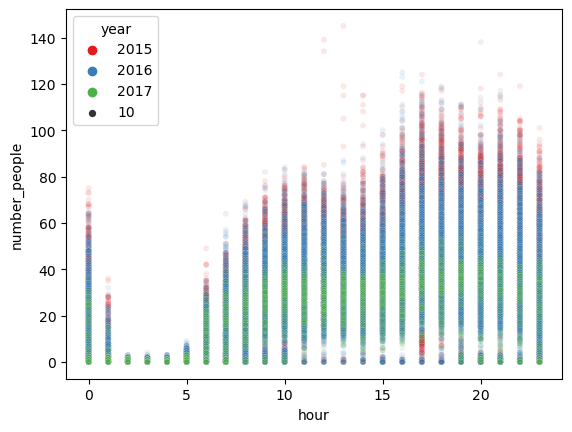

In [11]:
crw['year'] = crw['date'].dt.year
sns.scatterplot(x='hour', y='number_people', data=crw, hue='year', alpha=0.1, size=10, palette='Set1')

An interesting pattern emerged, throughout the years the number_of people has been decreasing.

In [62]:
crw[['year','number_people']].groupby('year').agg(['mean'])

,number_people
,mean
year,
2015,43.548304
2016,25.363974
2017,20.421053


The yearly daily average has been decreasing

In [64]:
crw[['year','number_people']].corr()['number_people']

year            -0.322591
number_people    1.000000
Name: number_people, dtype: float64

Year has a meaningful correlation with the number of people, let's add it to the model

MSE: 243.02
R2: 0.53
MAE: 11.74




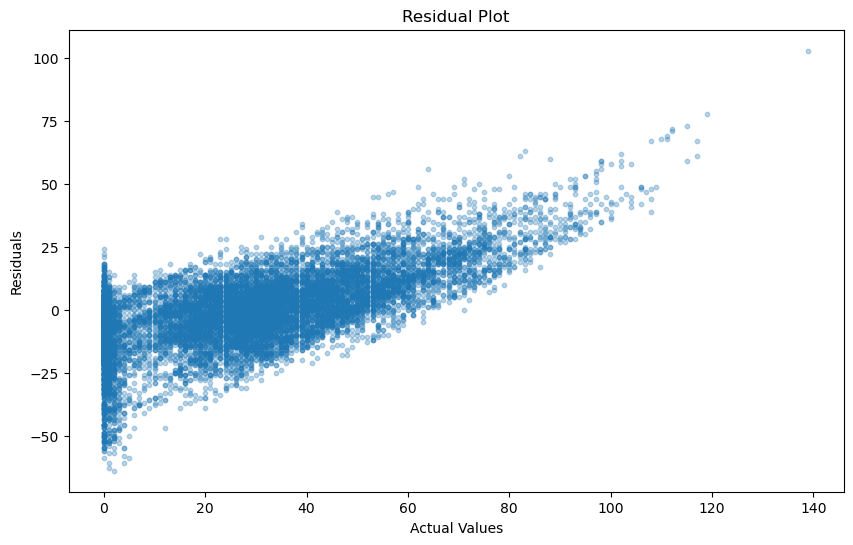

In [72]:
X = crw[['hour', 'temperature', 'is_during_semester', 'is_weekend','year']]
y = crw['number_people']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.20)

ss = StandardScaler() #normalize the data

X_train_s = ss.fit_transform(X_train)
X_test_s = ss.transform(X_test)

sgdr = SGDRegressor(max_iter=10000,
                    eta0=1e-4,
                    tol=1e-4)

sgdr.fit(X_train_s,y_train)

y_pred = np.round(sgdr.predict(X_test_s))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

residuals = y_test - y_pred

print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print('\n')
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, s=10, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

With this model we can explain 53% of the variability and decreased the MAE by less than 1, still the model is not great

### 2. Grid Search

In [76]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'eta0': [0.001, 0.1, 1, 10],
    'tol': [0.001, 0.1, 1, 10],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 500, 1000, 10000]
}

sgdr = SGDRegressor()


grid_search = GridSearchCV(sgdr, param_grid, cv=5)
grid_search.fit(X_train_s, y_train)

print("Optimal Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.wa

Optimal Hyperparameters: {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'invscaling', 'max_iter': 10000, 'tol': 1}
Best Score: 0.5221304148145197


We were able to get a R2: 52.21%, lets try again.

In [77]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'eta0': [0.001, 1e-4, 1e-5],
    'tol': [0.001, 1e-4, 1e-5],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [10000]
}

sgdr = SGDRegressor()


grid_search = GridSearchCV(sgdr, param_grid, cv=5)
grid_search.fit(X_train_s, y_train)

print("Optimal Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Optimal Hyperparameters: {'alpha': 0.01, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 10000, 'tol': 0.001}
Best Score: 0.5220803313815487


Nothing promising, Although interesting that with a bigger learning step got better results (1e-4)

### 3. Turn it into a classification problem

In [8]:
crw['is_crowded'] = crw['number_people'].apply(lambda row: 1 if row > 45 else 0)
crw['is_crowded']

0        0
1        0
2        0
3        0
4        0
        ..
62179    0
62180    0
62181    0
62182    0
62183    0
Name: is_crowded, Length: 62184, dtype: int64

In [9]:
crw['is_crowded'].value_counts()

is_crowded
0    48289
1    13895
Name: count, dtype: int64

In [15]:
X = crw[['hour', 'temperature', 'is_during_semester', 'is_weekend', 'year']]
y = crw['is_crowded']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.20)

# no need to scale the data for classification

sgdc = SGDClassifier(max_iter=10000,
                    eta0=1e-4,
                    tol=1e-4,
                    class_weight='balanced')

sgdc.fit(X_train,y_train)

y_pred = np.round(sgdc.predict(X_test))

report = classification_report(y_true=y_test, y_pred=y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.43      0.60      9613
           1       0.33      0.97      0.50      2824

    accuracy                           0.55     12437
   macro avg       0.66      0.70      0.55     12437
weighted avg       0.83      0.55      0.57     12437



We are not really precise to tell if it is crowded, but we can tell really good when it is. Our accuracy is not at 55%.<br>
I think 'year' is causing some trouble here, let's check

In [16]:
X = crw[['hour', 'temperature', 'is_during_semester', 'is_weekend']]
y = crw['is_crowded']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.20)

# no need to scale the data for classification

sgdc = SGDClassifier(max_iter=10000,
                    eta0=1e-4,
                    tol=1e-4,
                    class_weight='balanced')

sgdc.fit(X_train,y_train)

y_pred = np.round(sgdc.predict(X_test))

report = classification_report(y_true=y_test, y_pred=y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      9613
           1       0.56      0.47      0.51      2824

    accuracy                           0.80     12437
   macro avg       0.71      0.68      0.69     12437
weighted avg       0.79      0.80      0.79     12437



Our model now is capable of telling if it is or if it isn't crowded 80% of the time, much better than the previous versions

### 4. Time series forecasting

This could be the best approach but it is out of the scope of this project, but let's visualize how the time series looks like.

In [25]:
mean_ts = crw[['date','number_people']].groupby('date').agg(['mean'])
mean_ts = pd.DataFrame(mean_ts)
mean_ts

,number_people
,mean
date,
2015-08-15 00:00:11+00:00,37.0
2015-08-15 00:20:14+00:00,45.0
2015-08-15 00:30:15+00:00,40.0
2015-08-15 00:40:16+00:00,44.0
2015-08-15 00:50:17+00:00,45.0
...,...
2017-03-19 01:42:28+00:00,23.0
2017-03-19 01:52:35+00:00,21.0


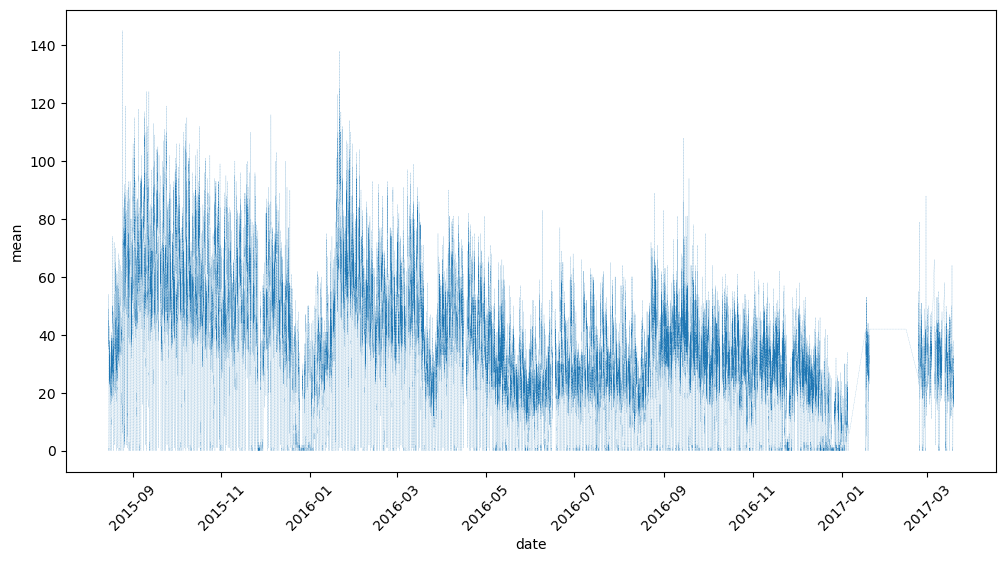

In [28]:
mean_ts.columns = ['mean']

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='mean', data=mean_ts, linestyle=':', linewidth=0.2)
plt.xticks(rotation=45)
plt.show()